# ML Project 2: Segmentation of aerial images

Instructions: 
- exploratory data analysis to understand your dataset and your features
- feature processing and engineering to clean your dataset and extract more meaningful information
- implement and use machine learning methods on real data
- analyze your model and generate predictions using those methods and report your findings

**Submission deadline**. Dec 17th, 2020 (at 16:00 afternoon, sharp)

Deliverables at a glance. (More details and grading criteria further down)
- Written Report. You will write a maximum 4 page PDF report on your ndings, using LaTeX.
- Code. In Python. External libraries are allowed, if properly cited.
- Competitive Part. To give you immediate feedback and a fair ranking, we use the competition platform AIcrowd.com to score your predictions. You can submit whenever and almost as many times as you like, up until the final submission deadline.

**Goal**: For this problem, we provide a set of satellite/aerial images acquired from GoogleMaps. We also provide ground-truth images where each pixel is labeled as {road, background}. Your goal is to train a classifier to segment roads in these images, i.e. assign a label {road=1, background=0} to each pixel. Please see detailed instructions on the course github.

Good summary:https://neptune.ai/blog/image-segmentation-in-2020

### Imports

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import tensorflow as tf
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from skimage import measure
from numpy import linalg as LA
import shutil

import warnings
warnings.filterwarnings('ignore') 

# helper functions from lab (load csv, create prediction, etc)
from helper_functions.helper_functions import *
# script to reconstruct an image from the sample submission file
from helper_functions.submission_to_mask import *

#script to make a submission file from a binary image:
from helper_functions.mask_to_submission import *

# Baseline for machine learning project on road segmentation.
from helper_functions.tf_aerial_images import *

# Baseline for machine learning project on road segmentation.
from helper_functions.helper_Marijn import *

%load_ext autoreload
%autoreload 2



/Users/marijnvandermeer/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/marijnvandermeer/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/marijnvandermeer/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/marijn

Set CUDA if available

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data pre-processing: 

File descriptions:
- `training` - the training set consisting of images with their ground truth
- `test_set_images` - the test set
- `sampleSubmission.csv` - a sample submission file in the correct format
- `mask_to_submission.py` - script to make a submission file from a binary image
- `submission_to_mask.py` - script to reconstruct an image from the sample submission file
- `tf_aerial_images.py` - Baseline for machine learning project on road segmentation. This simple baseline consits of a CNN with two convolutional+pooling layers with a soft-max loss


The sample submission file contains two columns: 
- first column corresponds to the image id followed by the x and y top-left coordinate of the image patch (16x16 pixels)
- second column is the label assigned to the image patch

#### Paths to data: 

In [30]:
path = Path('../data/training/')
path_test = Path('../data/test_set_images/')

path_train = path /'images'
path_GT = path / 'groundtruth'

### Pixel range: 

In [5]:
f_train_names = get_image_files(path_train)
f_gt_names = get_image_files(path_GT)

In [89]:
mask = open_mask(f_gt_names[0])
img = open_image(f_train_names[0])
img_gt = open_image(f_gt_names[0])

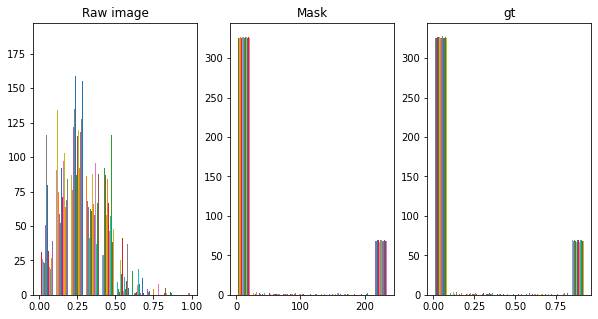

In [90]:
fig, axs = plt.subplots(1,3, figsize = (10, 5))
axs[0].hist(img.data[0])
axs[0].set_title('Raw image')
axs[1].hist(mask.data[0])
axs[1].set_title('Mask')
axs[2].hist(img_gt.data[0])
axs[2].set_title('gt');

Comment: masks shifts data to `[0,255]` pixel range. Original data also in 0,1 pixel range. Change everything to 0,255 ? 

In [6]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

Change one image to 0,255:

In [ ]:
plt.hist(img_float_to_uint8(img.data.numpy())[0,:,:]);

In [ ]:
mask = open_mask(f_gt_names[0])
img = open_image(f_train_names[0])
mask.show(figsize=(5, 5),  cmap='Greys_r'), img.show(figsize=(5, 5))
src_size = np.array(mask.shape)[1:]
print(f'Mask shape: {np.array(mask.shape)}')
print(f'Image shape: {np.array(img.shape)}')

Comment: problem not same pixel range ? 

### Create patches: 

https://medium.com/analytics-vidhya/a-simple-cloud-detection-walk-through-using-convolutional-neural-network-cnn-and-u-net-and-bc745dda4b04

In [75]:
f_train_names = get_image_files(path_train)
f_gt_names = get_image_files(path_GT)

In [76]:
# Extract patches from input images
patch_size = 16  # each patch is 16*16 pixels

# Number of images to extract patches
N = 20
img_patches = [
    img_crop(mpimg.imread(img), patch_size, patch_size)
    for img in f_train_names[:N]
]
gt_patches = [
    img_crop(mpimg.imread(img), patch_size, patch_size) for img in f_gt_names[:N]
]

# Linearize list of patches
img_patches = np.asarray([
    img_patches[i][j] for i in range(len(img_patches))
    for j in range(len(img_patches[i]))
])
gt_patches = np.asarray([
    gt_patches[i][j] for i in range(len(gt_patches))
    for j in range(len(gt_patches[i]))
])

print(f'Number of patches: {len(img_patches)} created from {N} images')
print(f'Shape of patches: {img_patches.shape[1]}')

patch_shape = img_patches.shape[1]

Number of patches: 12500 created from 20 images
Shape of patches: 16


create RGB PIL image from patches and save them. To meet the fast.ai requirements, we should organize our data into data/images and data/labels manually.

In [77]:
if not (path/'patches/images').exists():
    (path/'patches/images').mkdir()

if not (path/'patches/labels').exists():
    (path/'patches/labels').mkdir()
    
path_data = Path('../data/training/patches')
path_lbl = path_data/'labels'
path_img = path_data/'images'

In [78]:
for i in range(len(img_patches)):
    rgb_patch = Image.fromarray((256*img_patches[i]).astype(np.uint8), 'RGB')
    rgb_patch.save(path_img/f'patch_{i}.png')

need to convert the ground truth images to values 0 (no road) and 1 (road) and store them into a folder called ‘labels’.

In [79]:
for i in range(len(gt_patches)):
    # change values from 255 to 1
    im = Image.fromarray(np.where(gt_patches[i]==255, 1, 0).astype(np.uint8))
    im.save(path_lbl/f'patch_{i}.png')

In [80]:
# get images and labels filenames
img_names = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
print(len(img_names), len(lbl_names))

12500 12500


Create a function to map images to respective masks and test it with open_image and open_mask functions that load them into tensors

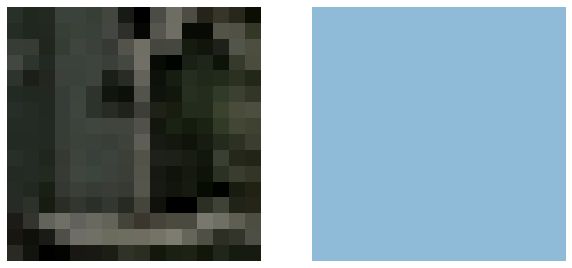

In [81]:
def get_lbl_fn(img_fn: Path):
    img_name = img_fn.name
    lbl_name = img_name.replace('rgb', 'gt')
    return img_fn.parent.parent / ('labels/' + lbl_name)


fname = path_img / 'patch_7.png'
img = open_image(fname)
mask = open_mask(get_lbl_fn(fname))

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

img.show(ax[0])
mask.show(ax[1])

Instead of using the entire set of 8400 images as training, we will let the library divide them into training (80%) and validation (20%) sets. Also, we will use some data augmentation. Data augmentation is a technique to increase the number of training samples by applying some random transformations like rotation, flipping, warp, and others.  Data Bunch keeps track of the samples and respective labels and, in the case of image segmentation, also merges both for a fast visualization

In [82]:
src = (SegmentationItemList.from_folder(
    path_img).split_by_rand_pct().label_from_func(get_lbl_fn,
                                                  classes=['rest', 'road']))

data = (src.transform(get_transforms(flip_vert=True),
                      size=patch_shape,
                      tfm_y=True).add_test(ImageList.from_folder(path_test),
                                           tfms=None,
                                           tfm_y=False).databunch(
                                               bs=4).normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (10000 items)
x: SegmentationItemList
Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16)
y: SegmentationLabelList
ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16)
Path: ../data/training/patches/images;

Valid: LabelList (2500 items)
x: SegmentationItemList
Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16)
y: SegmentationLabelList
ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16)
Path: ../data/training/patches/images;

Test: LabelList (50 items)
x: SegmentationItemList
Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16)
y: EmptyLabelList
,,,,
Path: ../data/training/patches/images

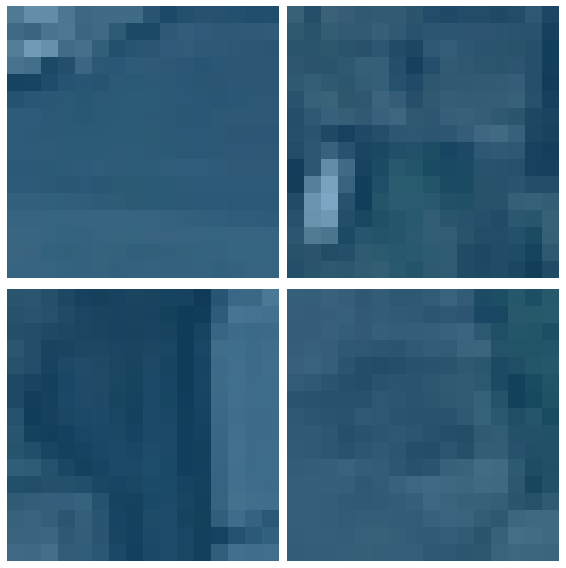

In [83]:
data.show_batch(2)

## Training:

### Model:
pre-trained ResNet 34 version of the U-Net, that has 34 layers in the contracting path. To create it, we will define a accuracy function, to measure the performance of the mode, the weight decay (regularization to avoid overfitting of the model) value and the learning rate (rate that will be multiplied to the gradient to adjust parameters during back-propagation step).

In [85]:
def acc_metric(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

wd = 1e-2

lr=1e-3

learn = unet_learner(data, models.resnet34, metrics=acc_metric, wd=wd)

epoch,train_loss,valid_loss,acc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


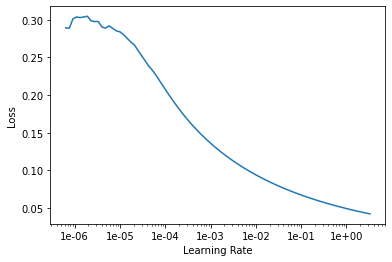

In [86]:
lr_find(learn)
learn.recorder.plot()

### First cycle:

In [87]:
sim = 1

In [88]:
lr = 1e-2

In [89]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    """
    do_fit: fits during 10 epochs with feature loss. 
    """
    learn.fit_one_cycle(3, lrs, pct_start=pct_start)
    learn.save(save_name, return_path=True)
    learn.show_results(rows=1, imgsize=10)
    learn.recorder.plot_losses()
    learn.recorder.plot_metrics()

In [ ]:
do_fit('sim{}_1a'.format(sim), slice(lr * 10))

epoch,train_loss,valid_loss,acc_metric,time
0,0.000000,0.000000,1.000000,26:35
1,0.000000,0.000000,1.000000,29:07


In [ ]:
img = learn.data.valid_ds.x[22]
mask = learn.data.valid_ds.y[22]
pred = learn.predict(img)[0]

fig, ax = plt.subplots(1,3, figsize=(12,6))

img.show(ax[0])
mask.show(ax[1])
pred.show(ax[2])

## Create predictions :
Your predictions must be in .csv format, see sample-submission.csv. You must use the same datapoint ids as in the test set test.csv. To generate .csv output from Python, use our provided helper functions in helpers.py (see Project 1 folder on github).